# First Look at AuxTel Data
Originally written by Alex Broughton

In [1]:
! eups list -s | grep lsst_distrib
! eups list -s | grep cp_pipe
! eups list -s | grep ip_isr

lsst_distrib          g4213664e8e+0dcb05a918 	current w_2023_47 setup
cp_pipe               gee0cc65525+36a99e9d86 	current w_2023_47 setup
ip_isr                g5bb47c1068+ae6a8c18b9 	current w_2023_47 setup


In this notebook, we will explore how to use the data butler to access sky data from the LATISS instrument on AuxTel. As an example, we will fit the dependence of BF effect on color using on-sky data. We will learn how to access, reduce, and model the data using the data Butler attatched to USDF's $\texttt{/repo/embargo}$. The data is based on AuxTel data from the night of 2023-08-03/17/29.

You can find the most recent data here:
$\texttt{https://roundtable.lsst.codes/rubintv/summit/auxtel/historical/2023-08-03}$




In [2]:
# Generic imports
import os
import numpy as np
import glob
from astropy.io import fits
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import Latiss
camera = Latiss().getCamera()
from matplotlib.pyplot import cm
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker


##### First, I'll setup the space and define some utility functions that will be useful down the line.

In [3]:
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

def get_astropy_wcs(image, verbose=False):
    """
    Get an astropy WCS object from an lsst.afw.image metadata WCS format
    
    Parameters
    ----------
    image: lsst.afw.image._exposure.ExposureF
        Input image with Fits Stadard WCS metadata

    Returns
    -------
    wcs: astropy.wcs.wcs.WCS
        Astropy WCS for the image object.
    """
    
    from astropy.wcs import WCS

    if verbose:
        print(image.getWcs())
    
    wcs_dict = dict()
    for val in image.getWcs().getFitsMetadata():
        wcs_dict[str(val)] = image.getWcs().getFitsMetadata()[str(val)]

    return WCS(wcs_dict)

def get_astropy_wcs_from_image_file(image_fits):
    """
    Get an astropy WCS object from an image fits file which contains 
    lsst.afw.image 
    
    Parameters
    ----------
    image: lsst.afw.image._exposure.ExposureF
        Input image with Fits Stadard WCS metadata

    Returns
    -------
    wcs: astropy.wcs.wcs.WCS
        Astropy WCS for the image object.
    """
    from astropy.wcs import WCS
    hdu = fits.open(image_fits)
    wcs = WCS(hdu['SkyWcs'].header)
    hdu.close()
    
    return wcs
    

def find_stars_on_sky(image):
    """
    Will identify all 5 sigma sources in an image and return a catalog
    of the star parameters. Uses DAOStarFinder (Stetson 1987; PASP 99, 191).
    
    Parameters
    ----------
    image: lsst.afw.image._exposure.ExposureF
        Input image with Fits Stadard WCS metadata

    Returns
    -------
    catalog: astropy.table.Table
        Astropy table of star-like objects
    """

    from astropy.stats import sigma_clipped_stats
    from photutils.datasets import load_star_image
    from photutils.detection import DAOStarFinder
    from astropy.wcs import WCS

    data = image.getImage().getArray()
    wcs = get_astropy_wcs(image)
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)   

    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
    sources = daofind(data - median)  

    for col in sources.colnames:  
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f'  # for consistent table output

    sky_coords = [wcs.pixel_to_world(source['xcentroid'], source['ycentroid']).transform_to('galactic') for source in sources]
    
    sources.add_columns([[c.l for c in sky_coords], [c.b for c in sky_coords]], names=['l (deg)', 'b (deg)'])
    
    #sources.pprint(max_width=76)  
    
    return sources 


def get_2nd_mom_from_hsm_result(results):
    """
    Calculate second moments from HSM adative moment result
    derived by galsim HSM module (ShapeData object). 
    """
    e1 = results.observed_shape.e1
    e2 = results.observed_shape.e2
    sigma = results.moments_sigma
    sigma_ave = sigma / (1 - e1**2 - e2**2 )**(0.25) 
    Ixx = (1+e1) * sigma_ave**2
    Iyy = (1-e1) * sigma_ave**2
    Ixy = e2 * (sigma_ave**2) 
    
    return Ixx, Iyy, Ixy


def get_star_stats(stars,image, ind, showSpot=True):
    """ 
    Derive photometry for a source in an image using a
    re-implementation of the HSM algorithm in galsim.
    
    Parameters
    ----------
    stars: arbitrary table type
        Initial catalog of stars with something like 'x/ycentroid'
        or 'base_SdssCentroid_y'
    image: lsst.afw.image._exposure.ExposureF
        Input image with Fits Stadard WCS metadata
    ind: int
       Index of star in the catalog to compute statistics on.
    showSpot: int
       Display a stamp image of the star.

    Returns
    -------
    stamp: numpy.ndarray
        Stamp around the selected star
    result: galsim ShapeData object
        HSM adaptive moment result on the selected star

    """
    import galsim
    
    #image = imageobj.getImage().getArray()
    
    result = np.zeros((1, 4))
    star = stars[ind]

    (x,y) = (0,0)
    if 'xcentroid' in stars.columns:
        y = star['xcentroid']
        x = star['ycentroid']
    else:
        y = star['base_SdssCentroid_x']
        x = star['base_SdssCentroid_y']

    #r = np.sqrt(star['npix']/np.pi)
    s = 40

    xmin = int(max(0,x-s))
    xmax = int(min(image.shape[0]-1, x+s+1))
    ymin = int(max(0,y-s))
    ymax = int(min(image.shape[1]-1, y+s+1))
    stamp = galsim.Image(image[xmin:xmax,ymin:ymax])

    if showSpot:
        plt.imshow(image[xmin:xmax,ymin:ymax])

    try:
        res = galsim.hsm.FindAdaptiveMom(stamp)
        ixx,iyy,ixy = get_2nd_mom_from_hsm_result(res)
        result = [np.max(image[xmin:xmax,ymin:ymax]),ixx,iyy,ixy,res.moments_sigma,res.moments_amp]
    except:
        result = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
        
    
    return stamp.array,result

def loader(i, size, scaled=False):
    """ 
    Fun little function to be placed inside a loop to display a 
    progress bar when looping over many objects.

    Usage:
    for i in range(len(arr)):
        loader(i,len(arr))
        ...
        

    Parameters
    ----------
    i: int 
        Current index
    size: int
        Total size of the array being looped over.
    scaled: bool
        Whether to dispay a fixed length progress bar of 100 points (False),
        or display a progress bar that is the length of the array (True).

    """
    load = "." * int(((i+1)/size)*100)
    load_ext = " " * (100 - len(load))
    
    if scaled:
        load = "." * (i+1)
        load_ext = " " * (size - i - 1)

    print("[" + load + load_ext + "] " + f"{i+1}/{size} ({round((i+1) / size * 100., 0)}%)", end='\r')

    return 
    

First we are going to setup a butler to repository where the LATISS data is ingested on USDF ($\texttt{/repo/embargo}$). It normally takes 1-2 days after data is taken for it to be accessible from a butler repository.

You can process your own raw data into collections, or you can look at the Data Reduction Pipeline (DRP) processed images which should already be available to you. The DRP collections contain fully caliobrated images and tables of objects using the most up-to-date calibrations, and we will use those here.

Let's query all the collections that were processed with the most recent weekly release of the LSST Science Pipelines (w_2023_33):

In [4]:
repo = "/repo/embargo"
butler = Butler(repo)
registry = butler.registry

collections = []
for c in registry.queryCollections("LATISS/runs/AUXTEL_DRP_IMAGING*w_2023_33*"):
    collections.append(c)
    print(c) 

LATISS/runs/AUXTEL_DRP_IMAGING_2023-08A-07AB-05AB/w_2023_33/PREOPS-3613/20230821T153036Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-08A-07AB-05AB/w_2023_33/PREOPS-3613/20230822T175428Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-08A-07AB-05AB/w_2023_33/PREOPS-3613/20230823T142229Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-08A-07AB-05AB/w_2023_33/PREOPS-3613/20230828T145332Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-08A-07AB-05AB/w_2023_33/PREOPS-3613/20230828T153937Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-08A-07AB-05AB/w_2023_33/PREOPS-3613/20230825T142344Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-08A-07AB-05AB/w_2023_33/PREOPS-3613


Let's grab a smaller butler which contains a registry of data within just these collections. We will find all exposures that were imaged on or after 8/3/2023 in the SDSS i band and have an associated table of calibrated stars.
<br> The $\texttt{finalized_src_table}$ data type will contain a catalog of calibrated stars. 



In [5]:
subbutler = Butler(repo,collections=collections)
subregistry = subbutler.registry
refs = np.sort(list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='i' AND visit>=2023080300000")))

print(len(refs))

112


We now have a list of references which match specific images (visits in this case) and all their accompanying data products.

You can get any of the data types listed in the DRP pipeline associated with these visits. 

If you want the processed image, you can query postISRCCD or calexp. 
$\texttt{postISRCCD}$ is an image that has been run through ISR but has not been calibrated astrometrically or photometrically or with a PSF model.
It is a temporary intermediate object that will not be part of a release. In the future, $\texttt{calexps}$ will be called $\texttt{pvis}$, or “processed visit images”.
These will have final-final calibrations applied (the calexp has early calibrations). To get $\texttt{calexps}$, you must also pass the detector argument (there is only one sensor on AuxTel and its detector number is 0). If you want a $\texttt{postISRCCD}$, you will also need to supply an exposure number, which in this case is the same as the visit number since we are only taking one exposure/vist.

Example:

In [6]:
refs[0].dataId

{instrument: 'LATISS', visit: 2023080300277, band: 'i', physical_filter: 'SDSSi_65mm~empty'}

In [7]:
stars = subbutler.get('finalized_src_table', dataId = refs[0].dataId, collections=collections)
print(stars.columns)

Index(['id', 'coord_ra', 'coord_dec', 'parent', 'base_SdssCentroid_x',
       'slot_Centroid_x', 'base_SdssCentroid_y', 'slot_Centroid_y',
       'base_SdssCentroid_flag', 'base_GaussianFlux_flag_badCentroid',
       ...
       'modelfit_CModel_exp_apCorrErr', 'slot_ModelFlux_exp_apCorrErr',
       'modelfit_CModel_exp_flag_apCorr', 'slot_ModelFlux_exp_flag_apCorr',
       'modelfit_CModel_initial_apCorr', 'slot_ModelFlux_initial_apCorr',
       'modelfit_CModel_initial_apCorrErr', 'slot_ModelFlux_initial_apCorrErr',
       'modelfit_CModel_initial_flag_apCorr',
       'slot_ModelFlux_initial_flag_apCorr'],
      dtype='object', length=755)


In [8]:
for c in stars.columns:
    print(c)

id
coord_ra
coord_dec
parent
base_SdssCentroid_x
slot_Centroid_x
base_SdssCentroid_y
slot_Centroid_y
base_SdssCentroid_flag
base_GaussianFlux_flag_badCentroid
base_PsfFlux_flag_badCentroid
ext_convolved_ConvolvedFlux_0_flag_badCentroid
ext_convolved_ConvolvedFlux_1_flag_badCentroid
ext_convolved_ConvolvedFlux_2_flag_badCentroid
ext_convolved_ConvolvedFlux_3_flag_badCentroid
ext_convolved_ConvolvedFlux_flag_badCentroid
ext_photometryKron_KronFlux_flag_badInitialCentroid
ext_shapeHSM_HsmPsfMoments_flag_badCentroid
ext_shapeHSM_HsmShapeRegauss_flag_badCentroid
ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid
ext_shapeHSM_HsmSourceMoments_flag_badCentroid
modelfit_DoubleShapeletPsfApprox_flag_badCentroid
slot_Centroid_flag
base_SdssCentroid_flag_edge
base_GaussianFlux_flag_badCentroid_edge
base_PsfFlux_flag_badCentroid_edge
ext_convolved_ConvolvedFlux_0_flag_badCentroid_edge
ext_convolved_ConvolvedFlux_1_flag_badCentroid_edge
ext_convolved_ConvolvedFlux_2_flag_badCentroid_edge
ext_convo

In [9]:
image = subbutler.get('calexp', dataId = refs[0].dataId, detector=0,collections=collections)

<frozen _collections_abc>:860: FutureWarning: Call to deprecated method __iter__. (Using DataCoordinate as a Mapping is deprecated in favor of the .mapping and .required attributes, and will be dropped after v27.) -- Deprecated since version v27.
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/daf_butler/g593d1161a4+e6fa2bd6b4/python/lsst/daf/butler/dimensions/_coordinate.py:528: FutureWarning: Call to deprecated method keys. (Using DataCoordinate as a Mapping is deprecated in favor of the .mapping and .required attributes, and will be dropped after v27.) -- Deprecated since version v27.
  return iter(self.keys())
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/daf_butler/g593d1161a4+e6fa2bd6b4/python/lsst/daf/butler/dimensions/_coordinate.py:548: FutureWarning: Call to deprecated function (or staticmethod) graph. (DataCoordinate.graph is deprecated in favor of .dimensions, and will be dropped after v27.) -- Deprecated since version v27.
  return s

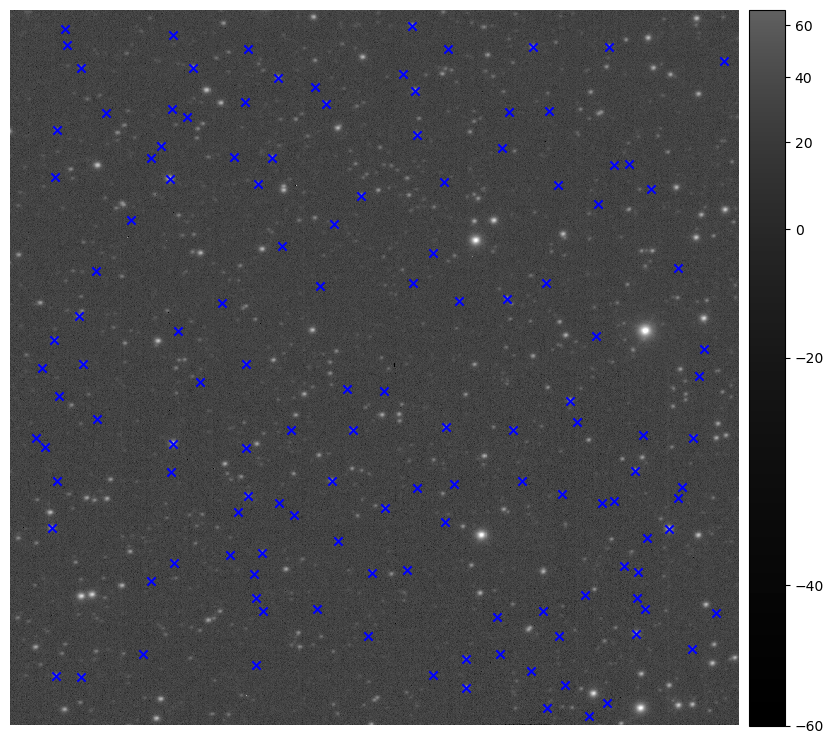

In [10]:
display(image)
plt.scatter(stars['base_SdssCentroid_x'],stars['base_SdssCentroid_y'], marker="x", color="blue")

Let's get a data from g, r, and i bands

In [11]:
%%time
refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='i' AND visit>=2023080300000")) 
data_list = []
for i, ref in enumerate(refs):
    data_list.append(subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections))
data_i = pd.concat(data_list)
del data_list

refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='r' AND visit>=2023080300000")) 
data_list = []
for i, ref in enumerate(refs):
    data_list.append(subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections))
data_r = pd.concat(data_list)
del data_list

refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='g' AND visit>=2023080300000")) 
data_list = []
for i, ref in enumerate(refs):
    data_list.append(subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections))
data_g = pd.concat(data_list)
del data_list


KeyboardInterrupt



In [12]:
plt.scatter(data_g['slot_ApFlux_instFlux'], data_g['slot_PsfShape_xx'] + data_g['slot_PsfShape_yy'], color="g")
plt.scatter(data_r['slot_ApFlux_instFlux'], data_r['slot_PsfShape_xx'] + data_r['slot_PsfShape_yy'], color="orange")
plt.scatter(data_i['slot_ApFlux_instFlux'], data_i['slot_PsfShape_xx'] + data_i['slot_PsfShape_yy'], color="red")
#plt.ylim(-10,85)
plt.xscale('log')

NameError: name 'data_g' is not defined

In [ ]:
def linear(x, alpha, beta, gamma, c):
    return alpha * x + beta*c + gamma

In [ ]:
mask = np.isfinite(data_r['slot_PsfShape_xx'])
data_r = data_r[mask]

In [ ]:
from scipy.optimize import curve_fit



poptg, ppcovg = curve_fit(linear, data_g['slot_ApFlux_instFlux'], data_g['slot_PsfShape_xx'], bounds=([-np.inf,-np.inf,20.,0.3],[np.inf,np.inf,60.,1.1]))
poptr, ppcovr = curve_fit(linear, data_r['slot_ApFlux_instFlux'], data_r['slot_PsfShape_xx'], bounds=([-np.inf,-np.inf,20.,1.0],[np.inf,np.inf,60.,2.0]))
popti, ppcovi = curve_fit(linear, data_i['slot_ApFlux_instFlux'], data_i['slot_PsfShape_xx'], bounds=([-np.inf,-np.inf,20.,0.0],[np.inf,np.inf,60.,1.0]))





In [ ]:

plt.rcParams.update({'font.size': 12})
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(15,2)) 
ax1.errorbar([poptg[0]], [3.0], xerr=[np.sqrt(ppcovg[0][0])], marker="o", color="g")
ax1.errorbar([poptr[0]], [2.0], xerr=[np.sqrt(ppcovr[0][0])], marker="o", color="orange")
ax1.errorbar([popti[0]], [1.0], xerr=[np.sqrt(ppcovi[0][0])], marker="o", color="red")

ax2.errorbar([poptg[1]], [3.0], xerr=[np.sqrt(ppcovg[1][1])], marker="o", color="g")
ax2.errorbar([poptr[1]], [2.0], xerr=[np.sqrt(ppcovr[1][1])], marker="o", color="orange")
ax2.errorbar([popti[1]], [1.0], xerr=[np.sqrt(ppcovi[1][1])], marker="o", color="red")

ax3.errorbar([poptg[2]], [3.0], xerr=[np.sqrt(ppcovg[2][2])], marker="o", color="g")
ax3.errorbar([poptr[2]], [2.0], xerr=[np.sqrt(ppcovr[2][2])], marker="o", color="orange")
ax3.errorbar([popti[2]], [1.0], xerr=[np.sqrt(ppcovi[2][2])], marker="o", color="red")

ax4.errorbar([poptg[3]], [3.0], xerr=[np.sqrt(ppcovg[3][3])], marker="o", color="g")
ax4.errorbar([poptr[3]], [2.0], xerr=[np.sqrt(ppcovr[3][3])], marker="o", color="orange")
ax4.errorbar([popti[3]], [1.0], xerr=[np.sqrt(ppcovi[3][3])], marker="o", color="red")

ax1.set_ylim(0,4)
ax2.set_ylim(0,4)
ax3.set_ylim(0,4)
ax4.set_ylim(0,4)

ax1.set_xlabel(r"$\alpha$")
ax2.set_xlabel(r"$\beta$")
ax3.set_xlabel(r"$\gamma$")
ax4.set_xlabel(r"$c$")

ax1.get_yaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)




In [ ]:
refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='i' AND visit>=2023080300000")) 
data_list_i = []
for i, ref in enumerate(refs):
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections)
    data_list_i.append(len(data))

refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='r' AND visit>=2023080300000")) 
data_list_r = []
for i, ref in enumerate(refs):
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections)
    data_list_r.append(len(data))

refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='g' AND visit>=2023080300000")) 
data_list_g = []
for i, ref in enumerate(refs):
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections)
    data_list_g.append(len(data))

In [ ]:
print(image.getMetadata())

In [ ]:
import galsim
    
def get_stars(data, img):
    image = img.getImage().getArray()
    results = np.full((len(data), 10), np.nan)
    for i in range(len(data)):
        star = data.iloc[i]
        result = np.full((1, 12), np.nan)

        y = star['base_SdssCentroid_x']
        x = star['base_SdssCentroid_y']

        s = 25

        xmin = int(max(0,x-s))
        xmax = int(min(image.shape[0]-1, x+s+1))
        ymin = int(max(0,y-s))
        ymax = int(min(image.shape[1]-1, y+s+1))
        stamp = galsim.Image(image[xmin:xmax,ymin:ymax])

        try:
            res = galsim.hsm.FindAdaptiveMom(stamp)
            ixx,iyy,ixy = get_2nd_mom_from_hsm_result(res)
            result = [ixx,iyy,ixy,np.max(image[xmin:xmax,ymin:ymax]),res.moments_sigma,res.moments_amp,x,y,res.observed_shape.e1,res.observed_shape.e2]
        except:
            continue
        
        results[i] = result
        
    return results
        
        
refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='i' AND visit>=2023080300000")) 
full_data_i = np.full((1,11),np.nan)
for i, ref in enumerate(refs):
    loader(i,len(refs))
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections)
    image = subbutler.get('calexp', dataId = ref.dataId, detector=0, exposure=ref.dataId['visit'], collections=collections)
    results = get_stars(data, image)
    #print(results.shape, np.asarray([times]).T.shape)
    times = np.asarray([image.getMetadata()['MJD']]*len(results))
    results = np.concatenate((results,np.asarray([times]).T),axis=1)
    full_data_i = np.vstack((full_data_i,results))

In [ ]:
%%time
refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='r' AND visit>=2023080300000")) 
full_data_r = np.full((1,11),np.nan)
for i, ref in enumerate(refs):
    loader(i,len(refs))
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections)
    image = subbutler.get('calexp', dataId = ref.dataId, detector=0, exposure=ref.dataId['visit'], collections=collections)
    results = get_stars(data, image)
    #print(results.shape, np.asarray([times]).T.shape)
    times = np.asarray([image.getMetadata()['MJD']]*len(results))
    results = np.concatenate((results,np.asarray([times]).T),axis=1)
    full_data_r = np.vstack((full_data_r,results))

In [ ]:
%%time
refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='g' AND visit>=2023080300000")) 
full_data_g = np.full((1,11),np.nan)
for i, ref in enumerate(refs):
    loader(i,len(refs))
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections)
    image = subbutler.get('calexp', dataId = ref.dataId, detector=0, exposure=ref.dataId['visit'], collections=collections)
    results = get_stars(data, image)
    #print(results.shape, np.asarray([times]).T.shape)
    times = np.asarray([image.getMetadata()['MJD']]*len(results))
    results = np.concatenate((results,np.asarray([times]).T),axis=1)
    full_data_g = np.vstack((full_data_g,results))

# Seeing vs exposure

In [22]:
pixscale = 0.0956783 # arcsec/pixel


In [23]:
fwhm_i = 2*np.sqrt(2*np.log(2)) * full_data_i[:,4] * pixscale
fwhm_r = 2*np.sqrt(2*np.log(2)) * full_data_r[:,4] * pixscale
fwhm_g = 2*np.sqrt(2*np.log(2)) * full_data_g[:,4] * pixscale

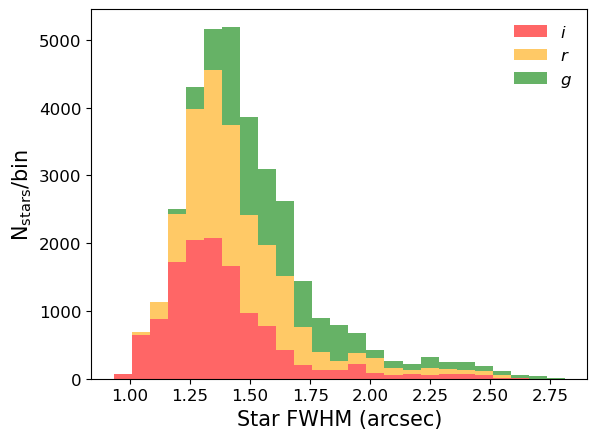

In [24]:
plt.figure()
_ = plt.hist([fwhm_i,fwhm_r,fwhm_g], stacked=True, bins=25, color=['r','orange','g'], label=['$i$','$r$','$g$'], alpha=0.6)
plt.ylabel("$\mathrm{N_{stars}}$/bin", fontsize=15)
plt.xlabel("Star FWHM (arcsec)", fontsize=15)
plt.legend(frameon=False)

In [25]:
MJDs_i = np.sort(np.unique(full_data_i[:,10]))
seeings_i = []
for mjd in MJDs_i:
    try:
        seeings_i.append(np.mean(fwhm_i[full_data_i[:,10]==mjd]))
    except:
        seeings_i.append(np.nan)
        
MJDs_r = np.sort(np.unique(full_data_r[:,10]))
seeings_r = []
for mjd in MJDs_r:
    try:
        seeings_r.append(np.mean(fwhm_r[full_data_r[:,10]==mjd]))
    except:
        seeings_r.append(np.nan)
        
        
MJDs_g = np.sort(np.unique(full_data_g[:,10]))
seeings_g = []
for mjd in MJDs_g:
    try:
        seeings_g.append(np.mean(fwhm_g[full_data_g[:,10]==mjd]))
    except:
        seeings_g.append(np.nan)

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'MJD')

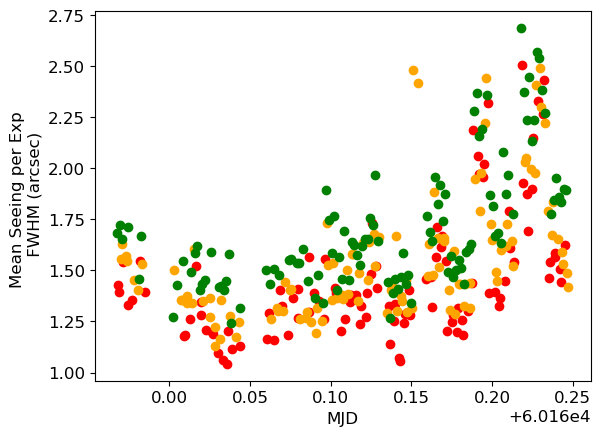

In [26]:
plt.scatter(MJDs_i, seeings_i, color="r")
plt.scatter(MJDs_r, seeings_r, color="orange")
plt.scatter(MJDs_g, seeings_g, color="g")
plt.ylabel("Mean Seeing per Exp \n FWHM (arcsec)")
plt.xlabel("MJD")

(0.0, 1.75)

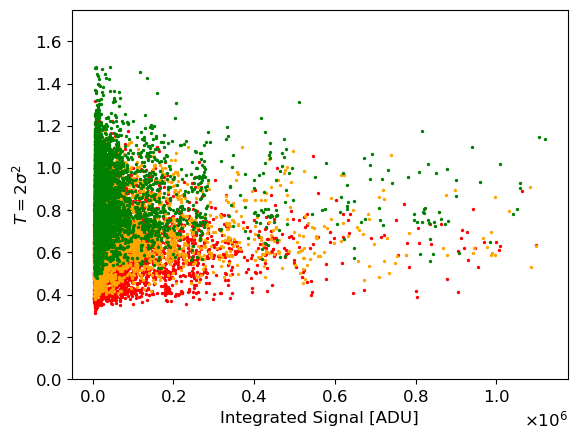

In [27]:
x = full_data_i[:,5]
y = 2*(full_data_i[:,4]*pixscale)**2
mask = (full_data_i[:,10] < 0.15+6.016e4)
plt.scatter(x[mask], y[mask], s=2, color="r")

x = full_data_r[:,5]
y = 2*(full_data_r[:,4]*pixscale)**2
mask = (full_data_r[:,10] < 0.15+6.016e4)
plt.scatter(x[mask], y[mask], s=2, color="orange")

x = full_data_g[:,5]
y = 2*(full_data_g[:,4]*pixscale)**2
mask = (full_data_g[:,10] < 0.15+6.016e4)
plt.scatter(x[mask], y[mask], s=2, color="g")

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
plt.ylabel("$T = 2\sigma^2$")
plt.xlabel("Integrated Signal [ADU]")
plt.ylim(0,1.75)

In [28]:
x = full_data_i[:,3]
y = 2*(full_data_i[:,4]*pixscale)**2
mask = (full_data_i[:,10] < 0.15+6.016e4)
poptg, ppcovg = curve_fit(linear, x[mask], y[mask], bounds=([-np.inf,-np.inf,20.,0.3],[np.inf,np.inf,60.,1.1]))


x = full_data_i[:,3]
y = 2*(full_data_i[:,4]*pixscale)**2
mask = (full_data_i[:,10] < 0.15+6.016e4)
poptg, ppcovg = curve_fit(linear, x[mask], y[mask], bounds=([-np.inf,-np.inf,20.,0.3],[np.inf,np.inf,60.,1.1]))


x = full_data_i[:,3]
y = 2*(full_data_i[:,4]*pixscale)**2
mask = (full_data_i[:,10] < 0.15+6.016e4)
poptg, ppcovg = curve_fit(linear, x[mask], y[mask], bounds=([-np.inf,-np.inf,20.,0.3],[np.inf,np.inf,60.,1.1]))

# poptr, ppcovr = curve_fit(linear, data_r['slot_ApFlux_instFlux'], data_r['slot_PsfShape_xx'], bounds=([-np.inf,-np.inf,20.,1.0],[np.inf,np.inf,60.,2.0]))
# popti, ppcovi = curve_fit(linear, data_i['slot_ApFlux_instFlux'], data_i['slot_PsfShape_xx'], bounds=([-np.inf,-np.inf,20.,0.0],[np.inf,np.inf,60.,1.0]))



# Stars per ccd

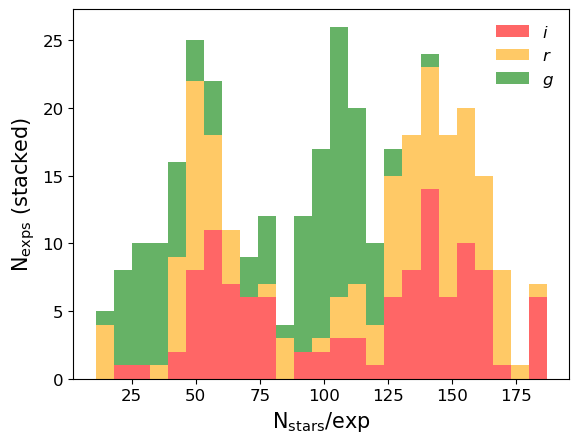

In [29]:
plt.figure()
_ = plt.hist([data_list_i,data_list_r,data_list_g], stacked=True, bins=25, color=['r','orange','g'], label=['$i$','$r$','$g$'], alpha=0.6)
plt.ylabel("$\mathrm{N_{exps}}$ (stacked)", fontsize=15)
plt.xlabel("$\mathrm{N_{stars}}$/exp", fontsize=15)
plt.legend(frameon=False)

In [30]:
np.sum(data_list_i), np.sum(data_list_r), np.sum(data_list_g)

(12454, 13030, 9107)

# PSF Modeling

(0.0, 1.5)

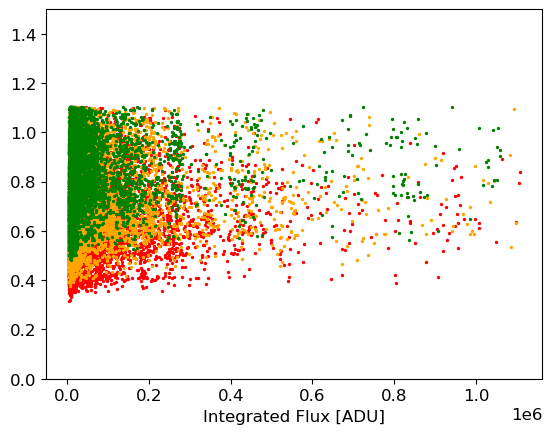

In [31]:
T_PSF = 2 * (full_data_i[:,4]*pixscale)**2
T_model =(full_data_i[:,9] + full_data_i[:,9])*(pixscale**2)
mask = (fwhm_i < 1.75)
plt.scatter(full_data_i[:,5][mask], T_PSF[mask], color="r", s=2)

T_PSF = 2 * (full_data_r[:,4]*pixscale)**2
T_model =(full_data_r[:,9] + full_data_r[:,9])*(pixscale**2)
mask = (fwhm_r < 1.75)
plt.scatter(full_data_r[:,5][mask], T_PSF[mask], color="orange", s=2)

T_PSF = 2 * (full_data_g[:,4]*pixscale)**2
T_model =(full_data_g[:,9] + full_data_g[:,9])*(pixscale**2)
mask = (fwhm_g < 1.75)
plt.scatter(full_data_g[:,5][mask], T_PSF[mask], color="g", s=2)

plt.xlabel("Integrated Flux [ADU]")
plt.ylim(0,1.5)

In [32]:
from scipy.stats import binned_statistic_2d

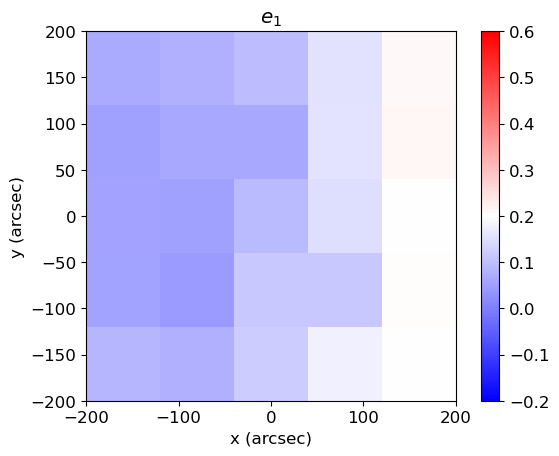

In [33]:
bins_per_side = 5
ind = 16

range_xy = np.asarray([[0., 4000.], [0., 4000.]])
x = full_data_i[:,6]
y = full_data_i[:,7]
values = full_data_i[:,8]
mask = ~np.asarray([np.any(np.isnan(star)) for star in full_data_i])
mask = mask * (full_data_i[:,10] == MJDs_i[ind])

statistic, x_edge, y_edge, bin_number = binned_statistic_2d(x[mask],y[mask], values=values[mask], statistic='mean',bins=[bins_per_side,bins_per_side])

plt.imshow(statistic, origin='lower', interpolation='nearest',extent=[-200,200,-200,200], vmin=-.2, vmax=.6, cmap='bwr')
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")
plt.title("$e_1$")
plt.colorbar()

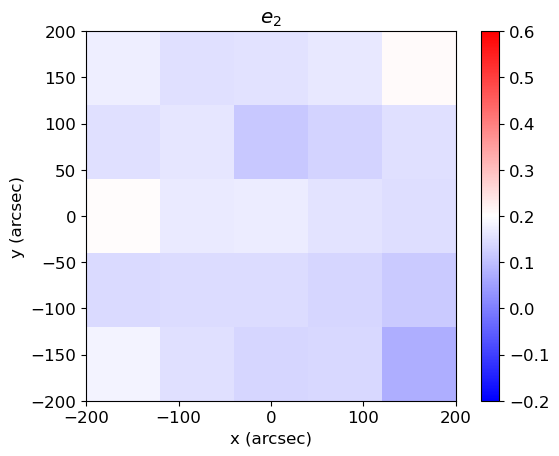

In [34]:
bins_per_side = 5

range_xy = np.asarray([[0., 4000.], [0., 4000.]])
x = full_data_i[:,6]
y = full_data_i[:,7]
values = full_data_i[:,9]
mask = ~np.asarray([np.any(np.isnan(star)) for star in full_data_i])
mask = mask * (full_data_i[:,10] == MJDs_i[ind])

statistic, x_edge, y_edge, bin_number = binned_statistic_2d(x[mask],y[mask], values=values[mask], statistic='mean',bins=[bins_per_side,bins_per_side])

plt.imshow(statistic, origin='lower', interpolation='nearest',extent=[-200,200,-200,200], vmin=-.2, vmax=.6, cmap='bwr')
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")
plt.title("$e_2$")
plt.colorbar()

(array([  26.,   48.,  149.,  277., 1548., 5350., 3408., 1382.,  235.,
          27.]),
 array([-0.55170304, -0.44909555, -0.34648806, -0.24388058, -0.14127309,
        -0.03866561,  0.06394188,  0.16654936,  0.26915685,  0.37176434,
         0.47437182]),
 <BarContainer object of 10 artists>)

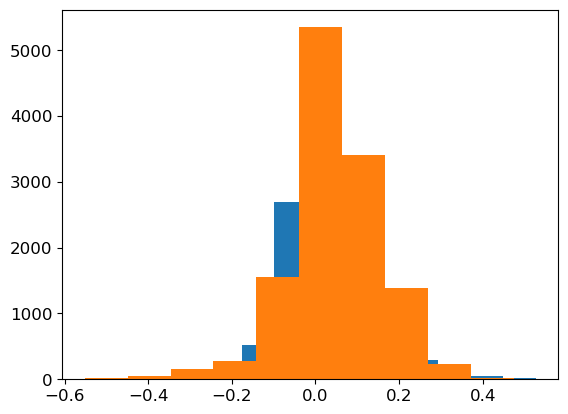

In [35]:
plt.hist(full_data_i[:,9])
plt.hist(full_data_i[:,8])

Animation

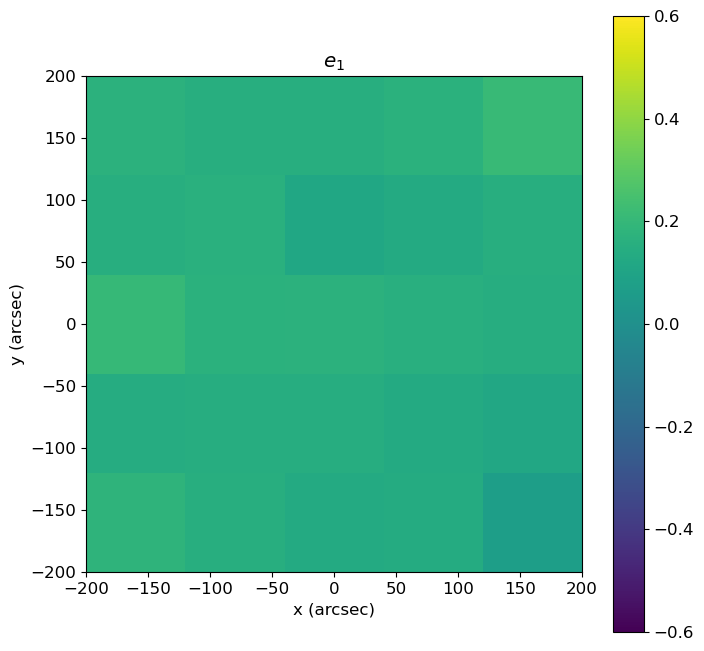

In [36]:
import matplotlib.animation as animation

def update_plot(n):
    range_xy = np.asarray([[0., 4000.], [0., 4000.]])
    x = full_data_i[:,6]
    y = full_data_i[:,7]
    values = full_data_i[:,8]
    mask = ~np.asarray([np.any(np.isnan(star)) for star in full_data_i])
    mask = mask * (full_data_i[:,10] == MJDs_i[n])

    statistic, x_edge, y_edge, bin_number = binned_statistic_2d(x[mask],y[mask], values=values[mask], statistic='mean',bins=[bins_per_side,bins_per_side])
    
    im.set_array(statistic)

    return im
fig = plt.figure(figsize=(8,8))
plt.imshow(statistic, origin='lower', extent=[-200,200,-200,200], vmin=-.6, vmax=.6)
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")
plt.title("$e_1$")
plt.colorbar()
ani = animation.FuncAnimation(fig, update_plot,frames=100, repeat=True)
plt.show()

# To do: PSF 2pt Correlation Function


In [37]:
import treecorr